# Param search

Imports

In [1]:
import logging

from tinkoff.invest.mock_services import MockedSandboxClient
from decimal import Decimal
from tinkoff.invest.strategies.moving_average.strategy_settings import (
    MovingAverageStrategySettings,
)
from tinkoff.invest import CandleInterval, MoneyValue
from tinkoff.invest.strategies.moving_average.signal_executor import (
    MovingAverageSignalExecutor,
)
from tinkoff.invest.strategies.moving_average.supervisor import (
    MovingAverageStrategySupervisor,
)
from tinkoff.invest.strategies.moving_average.strategy_state import (
    MovingAverageStrategyState,
)
from tinkoff.invest.strategies.moving_average.strategy import MovingAverageStrategy
from tinkoff.invest.strategies.moving_average.trader import MovingAverageStrategyTrader
from datetime import timedelta, datetime, timezone
from tinkoff.invest.typedefs import ShareId, AccountId
from tinkoff.invest.strategies.base.account_manager import AccountManager
from tinkoff.invest.strategies.moving_average.plotter import (
    MovingAverageStrategyPlotter,
)


logging.basicConfig(format="%(asctime)s %(levelname)s:%(message)s", level=logging.INFO)
logger = logging.getLogger(__name__)

Setup

In [2]:
token = 

Settings

In [3]:
figi = ShareId("BBG0013HGFT4")
account_id = AccountId("1337007228")
settings = MovingAverageStrategySettings(
    share_id=figi,
    account_id=account_id,
    max_transaction_price=Decimal(10000),
    candle_interval=CandleInterval.CANDLE_INTERVAL_1_MIN,
    long_period=timedelta(minutes=100),
    short_period=timedelta(minutes=50),
    std_period=timedelta(minutes=30),
)

Stocks for date

In [4]:
def start_datetime() -> datetime:
    return datetime(year=2022, month=2, day=16, hour=17, tzinfo=timezone.utc)


real_market_data_test_from = start_datetime() - timedelta(days=1)
real_market_data_test_start = start_datetime()
real_market_data_test_end = start_datetime() + timedelta(days=3)

Initial balance

In [5]:
balance = MoneyValue(currency="rub", units=20050, nano=690000000)

Trader

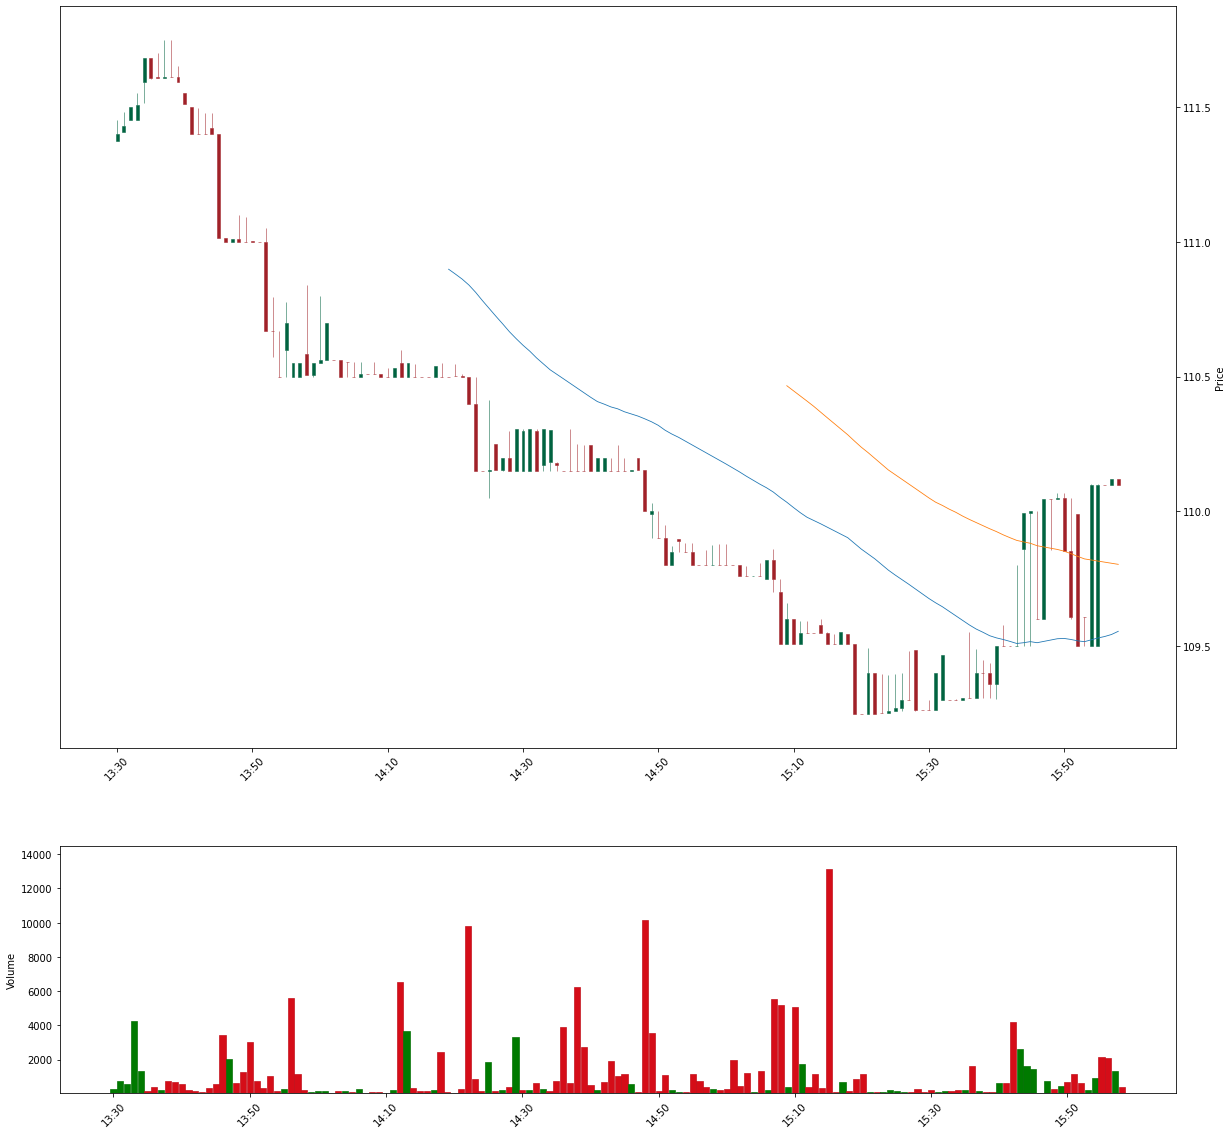

2022-03-15 21:00:05,649 INFO:9b1ca1a8bebe24b983bd1cd009ddd572 GetSandboxPortfolio
2022-03-15 21:00:05,650 INFO:Balance: 20050.69000000
2022-03-15 21:00:05,650 INFO:Refreshing data


In [ ]:
with MockedSandboxClient(
    token=token,
    balance=balance,
) as mocked_services:
    account_manager = AccountManager(
        services=mocked_services, strategy_settings=settings
    )
    state = MovingAverageStrategyState()
    strategy = MovingAverageStrategy(
        settings=settings,
        account_manager=account_manager,
        state=state,
    )
    supervisor = MovingAverageStrategySupervisor()
    signal_executor = MovingAverageSignalExecutor(
        services=mocked_services,
        state=state,
        settings=settings,
    )
    moving_average_strategy_trader = MovingAverageStrategyTrader(
        strategy=strategy,
        settings=settings,
        services=mocked_services,
        state=state,
        signal_executor=signal_executor,
        account_manager=account_manager,
        supervisor=supervisor,
    )
    plotter = MovingAverageStrategyPlotter(settings=settings)

    initial_balance = account_manager.get_current_balance()

    for i in range(50):
        logger.info("Trade %s", i)
        events = list(supervisor.get_events())
        plotter.plot(events)
        try:
            moving_average_strategy_trader.trade()
        except Exception:
            pass

In [ ]:
current_balance = account_manager.get_current_balance()
assert initial_balance != current_balance
logger.info("Initial balance %s", initial_balance)
logger.info("Current balance %s", current_balance)